# Experimental Design for Compton Scattering

This notebook produces coefficient figures in the main text of _Designing Optimal Experiments: An Application to Proton Compton Scattering_ by Jordan Melendez, Dick Furnstahl, Harald Grießhammer, Judith McGovern, Daniel Phillips, and Matt Pratola  (see [[arXiv:2004.11307]](https://arxiv.org/abs/2004.11307)). 
The figures are output to `./manuscript_figures/`.
All the other figures can be found in the `./main_manuscript_analysis.ipynb` and `./order_exponent_analysis.ipynb` notebooks.
Most of the detailed code resides in the `compton` package.

This notebook uses modules from standard Python packages, plotly, gptools, and the local `compton` package (install from the root directory of the repository with `pip install -e .`). 


#### Table of contents

1. [Set up kernel parameters](#kernel_parameters) 
1. [Read in data](#import_data)
1. [Truncation error size \[fig. 11\]](#truncation_error)
1. [Coefficient slices \[figs. 12-18\]](#coefficient_slices)
1. [Observable coefficients \[fig. 1\]](#observable_coefficients)


In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
import scipy as sp
from scipy.special import expit
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from os import path
from itertools import product

import gptools

from sklearn.utils.extmath import cartesian

from compton import expansion_parameter, expansion_parameter_momentum_transfer_cm, coefficients
from compton import order_transition_old, order_transition_lower_orders, order_transition_truncation 
from compton import expansion_parameter_cm
from compton import mass_proton, mass_neutron, omega_cm_from_lab, mass_pion, mass_delta
from compton import create_observable_set
from compton import omega_lab_cusp
from compton import observables_unique
from compton import ref_scale
from compton import observables_name_map
from compton import setup_rc_params
from compton import dsg_label
from compton import compute_expansion_summation_matrix
from compton import expansion_parameter_phillips
from compton import dsg_label

## Set up the defaults for figures

Set up global plot settings.

In [2]:
setup_rc_params()

## Set up kernel parameters<a id="kernel_parameters"></a>

In [3]:
# kernel_kwargs = {
#     ('dsg', 'proton'): dict(std=1, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=None, height=4),
#     ('1X', 'proton'): dict(std=0.4, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[0, 180], height=8),
#     ('1Z', 'proton'): dict(std=0.2, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=12),
#     ('2X', 'proton'): dict(std=0.2, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=8),
#     ('2Z', 'proton'): dict(std=1, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=None, height=4),
#     ('3', 'proton'): dict(std=0.5, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=4),
#     ('Y', 'proton'): dict(std=0.3, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[0, 180], height=4),
#     ('3Y', 'proton'): dict(std=0.3, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[0, 180], height=12),
#     ('3Yp', 'proton'): dict(std=0.3, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=4),
#     ('1Xp', 'proton'): dict(std=0.3, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=12),
#     ('1Zp', 'proton'): dict(std=0.2, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=4),
#     ('2Xp', 'proton'): dict(std=1, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[180], height=12),
#     ('2Zp', 'proton'): dict(std=0.5, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0], height=4),
#     #
#     ('dsg', 'neutron'): dict(std=2, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=None, height=None),
#     ('1X', 'neutron'): dict(std=0.4, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[0, 180], height=None),
#     ('1Z', 'neutron'): dict(std=0.2, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=None),
#     ('2X', 'neutron'): dict(std=0.5, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=None),
#     ('2Z', 'neutron'): dict(std=2, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=None, height=None),
#     ('3', 'neutron'): dict(std=0.5, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=None),
#     ('Y', 'neutron'): dict(std=0.3, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[0, 180], height=None),
#     ('3Y', 'neutron'): dict(std=0.3, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=None),
#     ('3Yp', 'neutron'): dict(std=0.3, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=None),
#     ('1Xp', 'neutron'): dict(std=0.2, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=None),
#     ('1Zp', 'neutron'): dict(std=0.2, ls_omega=50, ls_degrees=50, noise_std=0, degrees_zeros=[0, 180], height=None),
#     ('2Xp', 'neutron'): dict(std=1, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[180], height=None),
#     ('2Zp', 'neutron'): dict(std=1.5, ls_omega=50, ls_degrees=100, noise_std=0, degrees_zeros=[0], height=None),
# }

## Read in data<a id="import_data"></a>

In [4]:
observables_name_inverse_map = {val: key for key, val in observables_name_map.items()}

In [5]:
df = pd.read_csv('../data/compton_observables_new.csv', index_col=False)
df['observable'] = df['observable'].replace(observables_name_map)
# observables_unique = df['observable'].unique()

obs_file = path.abspath('../data/polarisabilities-coefficient-table-for-all-observables_20191111_jam.csv')
df_ratio = pd.read_csv(obs_file, dtype={'observable': str})
df_ratio['observable'] = df_ratio['observable'].replace(observables_name_map)
df_ratio['nucleon'] = df_ratio['nucleon'].replace({'neutron': 'Neutron', 'proton': 'Proton'})

compton_obs = create_observable_set(df=df_ratio, cov_exp=0.)

obs_vals = [
    'crosssection', '1Xp', '1X', '1Zp', '1Z', '2Xp',
    '2X', '2Zp', '2Z', '3', '3Yp', '3Y', 'Y'
]

systems = ['Neutron', 'Proton']
order_map = {0: 0, 2: 1, 3: -1, 4: 2}
orders = np.array([0, 2, 3, 4])

scale_ref = True

In [6]:
df_dsg_ref = pd.read_csv('../data/yref-dsg.csv', index_col=False)
# df_dsg_ref['nucleon'] = df_dsg_ref['nucleon'].replace({'neutron': 'Neutron', 'proton': 'Proton'})

In [7]:
omega = df['omegalab [MeV]'].unique()
theta = df['thetalab [deg]'].unique()

In [8]:
X = cartesian([omega, theta])

In [9]:
Lambdab = 650

# R_script = (mass_delta - mass_proton) / Lambdab
# delta_omega = df['omegalab [MeV]'] / Lambdab
# Q_vals_phillips = np.vstack([
#     np.ones_like(delta_omega),
#     delta_omega ** 1 * R_script,
#     delta_omega ** 2 * R_script,
#     delta_omega ** 3 * R_script ** 2 * (mass_delta - mass_proton) / mass_pion,
#     delta_omega ** 3 * R_script ** 2
# ])

## Truncation error size<a id="truncation_error"></a>

In [10]:
# from compton import order_transition


# Fourth order is complete at low energy, so omitted is 5
# But it is not complete at high energy, so it goes to 1
# omitted_order = order_transition_old(5, 1, omega)
omitted_order = order_transition_truncation(5, omega, n_inf=1)

In [11]:
Q_vs_omega = expansion_parameter_cm(omega[:, None][:, [0,0]], Lambdab, mass=mass_proton, factor=0.5)

In [12]:
omitted_order

array([4.99999879, 4.99999826, 4.99999749, 4.99999638, 4.99999478,
       4.99999247, 4.99998914, 4.99998434, 4.99997742, 4.99996743,
       4.99995303, 4.99993226, 4.9999023 , 4.9998591 , 4.99979679,
       4.99970693, 4.99957733, 4.99939043, 4.99912091, 4.99873225,
       4.99817185, 4.99736388, 4.99619916, 4.99452055, 4.99210205,
       4.98861912, 4.98360656, 4.97639934, 4.96605054, 4.96074745,
       4.95779613, 4.95462546, 4.95139322, 4.9475613 , 4.94363265,
       4.9394142 , 4.91920772, 4.89985163, 4.85714286, 4.797168  ,
       4.713882  , 4.6       , 4.447533  , 4.24907289, 4.        ,
       3.70133404, 3.36216575, 3.        , 2.63783425, 2.29866596,
       2.        , 1.75092711, 1.552467  , 1.4       , 1.286118  ,
       1.202832  , 1.14285714, 1.10014837, 1.06997624, 1.04878049,
       1.03394946, 1.02360066, 1.01639344, 1.01138088, 1.00789795,
       1.00547945, 1.00380084, 1.00263612, 1.00182815, 1.00126775,
       1.00087909, 1.00060957, 1.00042267, 1.00029307])

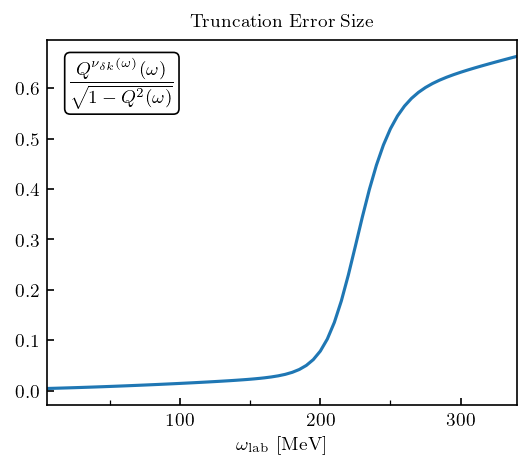

In [13]:
# Figure 11

fig, ax = plt.subplots(1,1, figsize=(3.4, 3))
ax.plot(omega, Q_vs_omega**omitted_order / np.sqrt(1 - Q_vs_omega**2))

ax.set_xticks([0, 100, 200, 300])
ax.set_xticks([50, 150, 250], minor=True)
ax.margins(x=0)
ax.text(
    0.05, 0.95, r'$\displaystyle\frac{Q^{\nu_{\delta k}(\omega)}(\omega)}{\sqrt{1 - Q^2(\omega)}}$',
    ha='left', va='top', transform=ax.transAxes, bbox=dict(boxstyle='round', facecolor='w')
)
ax.set_xlabel(r'$\omega_{\mathrm{lab}}$ [MeV]')
ax.set_title('Truncation Error Size')
fig.savefig('manuscript_figures/truncation_error_stdv')

In [14]:
# Q_no_correction = expansion_parameter_momentum_transfer_cm(X, Lambdab, mass_proton, include_correction=False)
# Q_no_correction = expansion_parameter_cm(X, Lambdab, mass_proton, factor=1.5)
Q_no_correction = expansion_parameter_cm(X, Lambdab, mass=mass_proton, factor=0.5)
Q_phil = np.broadcast_to(expansion_parameter_phillips(Lambdab), X.shape[0])
Q_correction = expansion_parameter_momentum_transfer_cm(X, Lambdab, mass_proton, include_correction=True)

Q_no_correction_mat = Q_no_correction.reshape(len(omega), len(theta))
Q_correction_mat = Q_correction.reshape(len(omega), len(theta))

# Q_no_correction_sum_mat = compute_expansion_summation_matrix(Q_no_correction, omitted_order)
# Q_correction_sum_mat = compute_expansion_summation_matrix(Q_correction, omitted_order)

# Do not include correlations
Q_no_correction_sum_mat = Q_no_correction_mat ** omitted_order[:, None] / np.sqrt(1 - Q_no_correction_mat**2)
Q_correction_sum_mat = Q_correction_mat ** omitted_order[:, None] / np.sqrt(1 - Q_correction_mat**2)

/Users/jordan.melendez/opt/miniconda3/envs/compton/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


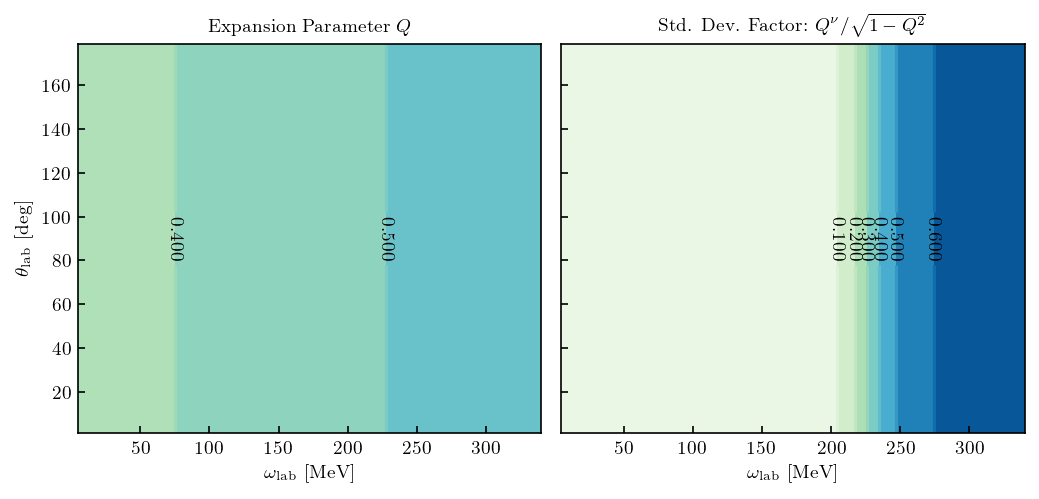

In [15]:
Q_contours = np.linspace(0, 1, 11)

cmap_Q = 'GnBu'

fig, axes = plt.subplots(1, 2, figsize=(7, 3.4), sharex=True, sharey=True)
axes[0].contourf(omega, theta, Q_no_correction_mat.T, vmin=0, vmax=1, levels=Q_contours, cmap=cmap_Q)
CS = axes[0].contour(omega, theta, Q_no_correction_mat.T, vmin=0, vmax=1, levels=Q_contours, cmap=cmap_Q)

axes[1].contourf(omega, theta, Q_no_correction_sum_mat.T, cmap=cmap_Q)
CS2 = axes[1].contour(omega, theta, Q_no_correction_sum_mat.T, cmap=cmap_Q)

axes[0].clabel(CS, Q_contours, inline=True, colors='k')
axes[1].clabel(CS2, inline=True, colors='k')
axes[0].set_title('Expansion Parameter $Q$')
axes[0].set_ylabel(r'$\theta_{\rm lab}$ [deg]')
axes[1].set_title(r'Std. Dev. Factor: $Q^{\nu} / \sqrt{1 - Q^2}$')
for ax in axes.ravel():
    ax.set_xlabel(r'$\omega_{\rm lab}$ [MeV]')

fig.tight_layout()

In [16]:
0.7**2 / (1 - 0.7**2)

0.96078431372549

/Users/jordan.melendez/opt/miniconda3/envs/compton/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


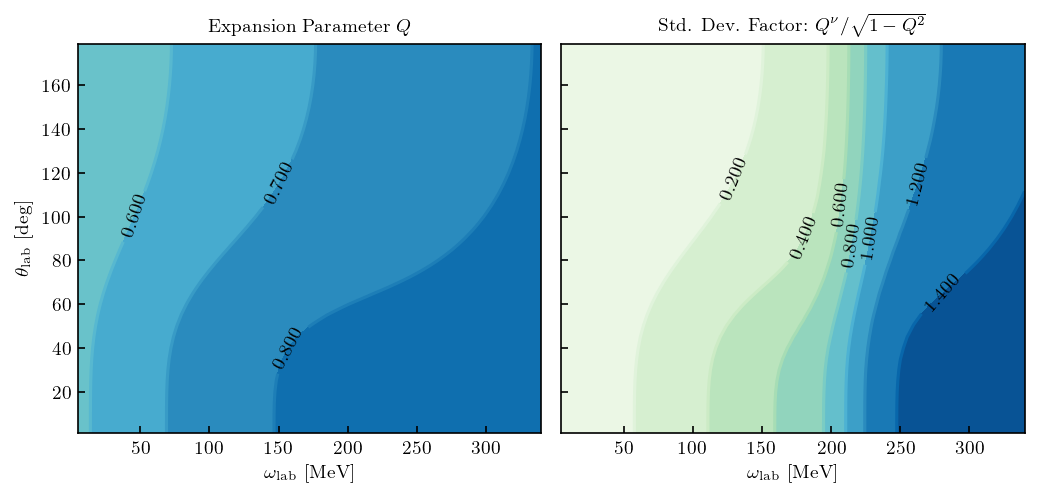

In [17]:
Q_contours = np.linspace(0, 1, 11)

fig, axes = plt.subplots(1, 2, figsize=(7, 3.4), sharex=True, sharey=True)
axes[0].contourf(omega, theta, Q_correction_mat.T, vmin=0, vmax=1, levels=Q_contours, cmap=cmap_Q)
CS = axes[0].contour(omega, theta, Q_correction_mat.T, vmin=0, vmax=1, levels=Q_contours, cmap=cmap_Q)
axes[1].contourf(omega, theta, Q_correction_sum_mat.T, cmap=cmap_Q)
CS2 = axes[1].contour(omega, theta, Q_correction_sum_mat.T, cmap=cmap_Q)

# axes[0].clabel(CS, Q_contours, inline=True, colors='k')
axes[0].clabel(CS, inline=True, colors='k')
axes[1].clabel(CS2, inline=True, colors='k')
axes[0].set_title('Expansion Parameter $Q$')
axes[0].set_ylabel(r'$\theta_{\rm lab}$ [deg]')
axes[1].set_title(r'Std. Dev. Factor: $Q^{\nu} / \sqrt{1 - Q^2}$')
for ax in axes.ravel():
    ax.set_xlabel(r'$\omega_{\rm lab}$ [MeV]')
# plt.clabel()
fig.tight_layout()
# fig.savefig('manuscript_figures/expansion_parameter_with_lorentz')

In [18]:
from compton.convergence import expansion_parameter_cm

In [19]:
from compton.convergence import ConvergenceAnalyzer

In [20]:
systems

['Neutron', 'Proton']

In [21]:
omega

array([  5.       ,  10.       ,  15.       ,  20.       ,  25.       ,
        30.       ,  35.       ,  40.       ,  45.       ,  50.       ,
        55.       ,  60.       ,  65.       ,  70.       ,  75.       ,
        80.       ,  85.       ,  90.       ,  95.       , 100.       ,
       105.       , 110.       , 115.       , 120.       , 125.       ,
       130.       , 135.       , 140.       , 145.       , 147.       ,
       148.       , 149.       , 149.9506926, 151.       , 152.       ,
       153.       , 157.       , 160.       , 165.       , 170.       ,
       175.       , 180.       , 185.       , 190.       , 195.       ,
       200.       , 205.       , 210.       , 215.       , 220.       ,
       225.       , 230.       , 235.       , 240.       , 245.       ,
       250.       , 255.       , 260.       , 265.       , 270.       ,
       275.       , 280.       , 285.       , 290.       , 295.       ,
       300.       , 305.       , 310.       , 315.       , 320. 

In [22]:
theta

array([  1,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 179])

In [23]:
train_low_energies = [50, 75, 100, 125]
# train_high_energies = [175, 200, 225, 250, 275, 300]
train_high_energies = [200, 225, 250]
train_degrees = [30, 50, 70, 90, 110, 130]
train_all = np.isin(X[:,0], train_low_energies + train_high_energies) & np.isin(X[:, 1], train_degrees)
train_above_cusp = np.isin(X[:,0], train_high_energies) & np.isin(X[:, 1], train_degrees)

In [24]:
train_all.sum()

42

In [25]:
train_above_cusp.sum()

18

In [26]:
# nonzero_below_threshold = ['2X', '2Z', '2Xp', '2Zp', '3']
# nonzero_at_leading_order = ['3', 'dsg']

# zero_at_t_0_and_180 = ['1X', '1Z', '2X', '3', 'Y', '3Y', '3Yp', '1Xp', '1Zp']
# c_deriv_zero_at_t0 = ['1Z', '3', '1Xp']
# c_deriv_zero_at_t180 = ['1Z', '2X', '3', '1Zp']

nonzero_below_threshold = ['2X', '2Z', '2Xp', '2Zp', '3']
nonzero_at_leading_order = ['3', 'dsg']

zero_at_t_0_and_180 = ['1X', '1Z', '2X', '3', 'Y', '3Y', '3Yp', '1Xp', '1Zp']
c_deriv_zero_at_t0 = ['1Z', '3', '1Xp', '2Z', '2Xp', 'dsg']
c_deriv_zero_at_t180 = ['1Z', '3', '1Zp', '2Z', '2Zp', 'dsg']

In [27]:
orders

array([0, 2, 3, 4])

In [28]:
breakdown = 650

In [29]:
from compton.convergence import RBFJump, ConditionalKernel
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

In [30]:
orders

array([0, 2, 3, 4])

In [31]:
rbf1 = RBF([1, np.inf])
rbf2 = RBF([np.inf, 2.3])
rbf3 = RBF([1, 2.3])

rbf_both = rbf1 * rbf2

In [32]:
X

array([[  5.,   1.],
       [  5.,   5.],
       [  5.,  10.],
       ...,
       [340., 170.],
       [340., 175.],
       [340., 179.]])

In [33]:
np.allclose(rbf3(X), rbf_both(X))

True

In [34]:
kern_test = gptools.SquaredExponentialKernel(
            initial_params=[1, 1], fixed_params=[True, True])
gp = gptools.GaussianProcess(kern_test)
gp.add_data(np.array([[0], [0]]), np.array([0, 0]), n=np.array([0, 1]))

## Coefficient slices (figs. 12-18)<a id="coefficient_slices"></a>

height 4
dsg [50, 75, 100, 125, 200, 225, 250]
Fit kernel: RBFJump(length_scale=[56.8, 64.1]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.91010581874018
[[0]
 [0]] [0. 1.]


/Users/jordan.melendez/opt/miniconda3/envs/compton/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


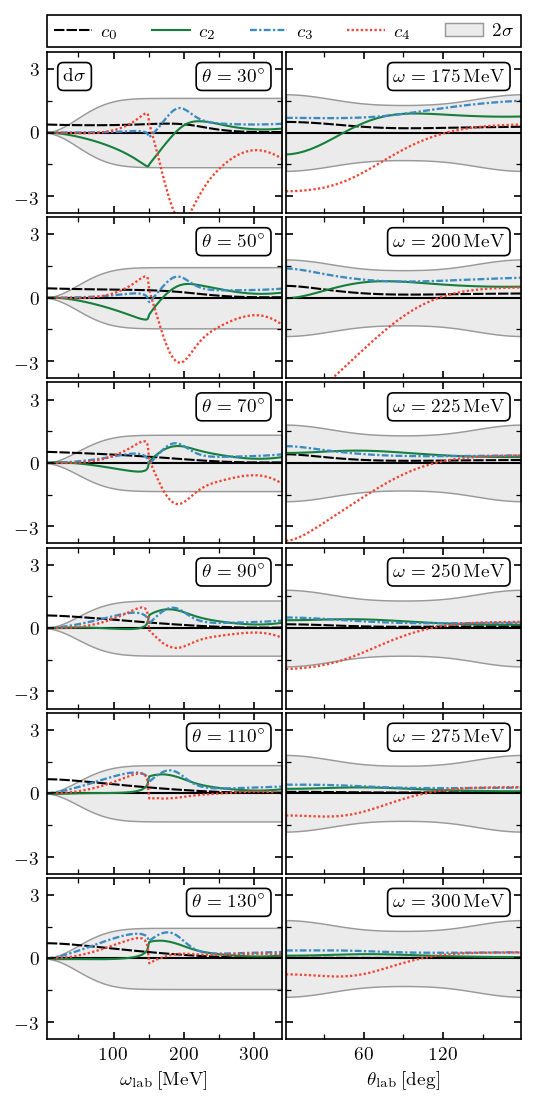

Fit kernel: RBFJump(length_scale=[55.7, 67.9]) + WhiteKernel(noise_level=0.0001)
cbar mean: 1.0449836538519304
dsg [50, 75, 100, 125, 200, 225, 250]
Fit kernel: RBFJump(length_scale=[40, 77.8]) + WhiteKernel(noise_level=0.0001)
cbar mean: 3.153032131614717
Fit kernel: RBFJump(length_scale=[34.3, 77.1]) + WhiteKernel(noise_level=0.0001)
cbar mean: 2.898736537221768
1X [200, 225, 250]
Fit kernel: RBFJump(length_scale=[35.6, 47.3]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.7278702208249153


/Users/jordan.melendez/opt/miniconda3/envs/compton/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


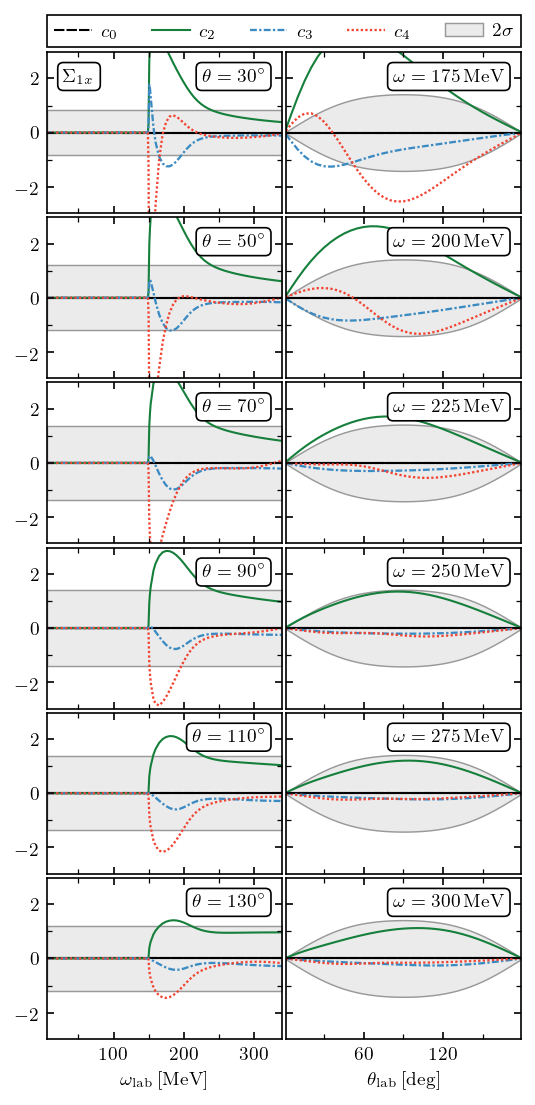

Fit kernel: RBFJump(length_scale=[35.5, 46.5]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.8065674202002526
1X [200, 225, 250]
Fit kernel: RBFJump(length_scale=[57.7, 49.4]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.6833104842859118
Fit kernel: RBFJump(length_scale=[59.6, 48.8]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.7804455846117659
1Z [200, 225, 250]
Fit kernel: RBFJump(length_scale=[33.7, 54.5]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.4580564678596544


/Users/jordan.melendez/opt/miniconda3/envs/compton/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


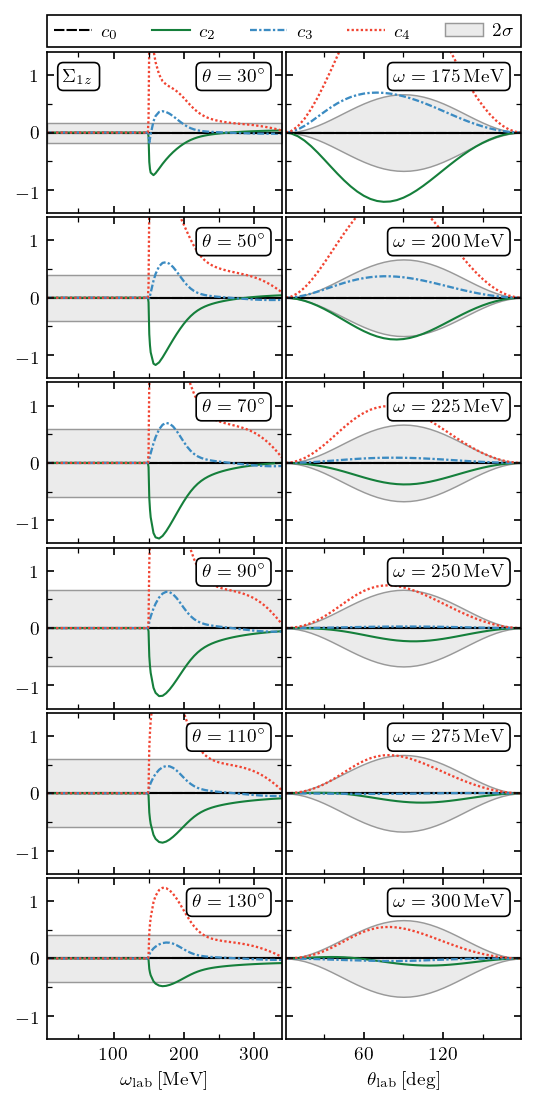

Fit kernel: RBFJump(length_scale=[34.5, 54.4]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.536053064385092
1Z [200, 225, 250]
Fit kernel: RBFJump(length_scale=[55.5, 42.5]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.4031682245015812
Fit kernel: RBFJump(length_scale=[56.2, 42.3]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.4627057939528208
2X [50, 75, 100, 125, 200, 225, 250]
Fit kernel: RBFJump(length_scale=[41, 38]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.5660897771547515
[[0]
 [0]] [0. 1.]


/Users/jordan.melendez/opt/miniconda3/envs/compton/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


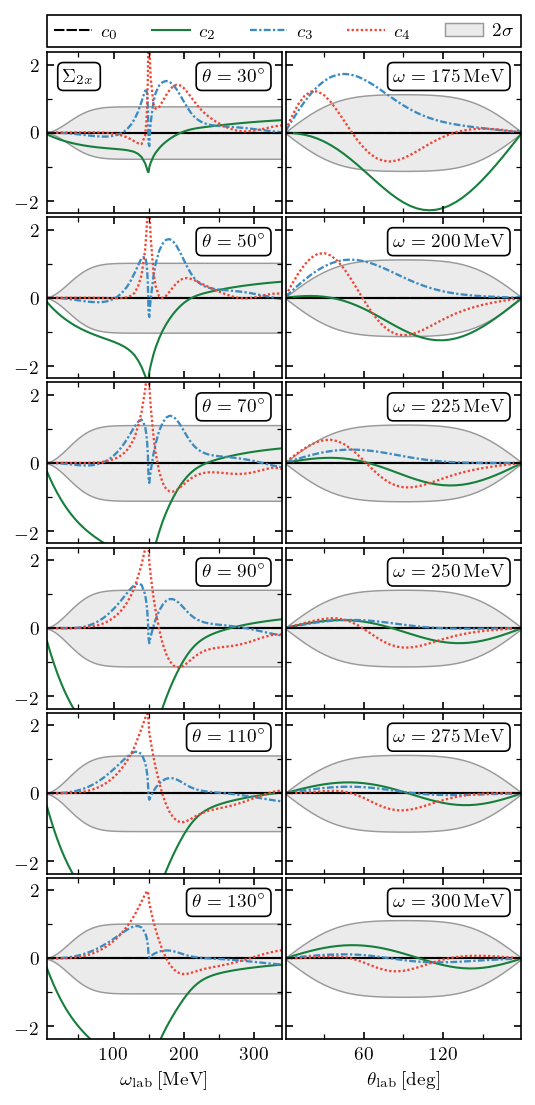

Fit kernel: RBFJump(length_scale=[42.2, 37.2]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.6034496391572596
2X [50, 75, 100, 125, 200, 225, 250]
Fit kernel: RBFJump(length_scale=[49.8, 39.3]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.7004209099193783
Fit kernel: RBFJump(length_scale=[47.2, 38.3]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.6857351046706427
2Z [50, 75, 100, 125, 200, 225, 250]
Fit kernel: RBFJump(length_scale=[47.4, 46.1]) + WhiteKernel(noise_level=0.0001)
cbar mean: 1.485458177793198
[[0]
 [0]] [0. 1.]


/Users/jordan.melendez/opt/miniconda3/envs/compton/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


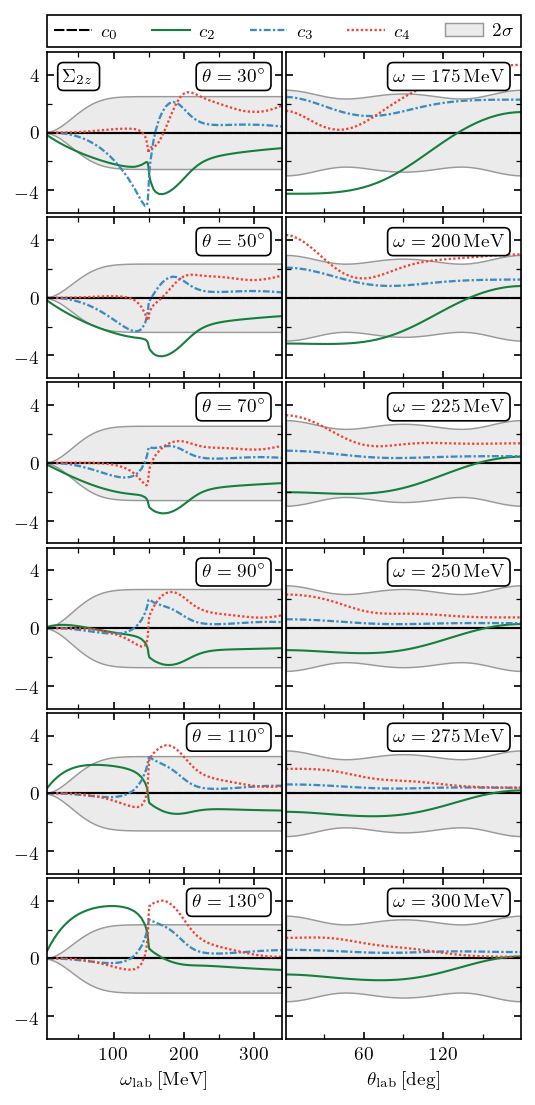

Fit kernel: RBFJump(length_scale=[49.5, 45.7]) + WhiteKernel(noise_level=0.0001)
cbar mean: 1.6290369842341519
2Z [50, 75, 100, 125, 200, 225, 250]
Fit kernel: RBFJump(length_scale=[45.9, 52.7]) + WhiteKernel(noise_level=0.0001)
cbar mean: 2.0767082001486736
Fit kernel: RBFJump(length_scale=[41.1, 52.8]) + WhiteKernel(noise_level=0.0001)
cbar mean: 2.005180468943952
3 [50, 75, 100, 125, 200, 225, 250]
Fit kernel: RBFJump(length_scale=[50.5, 35.5]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.6911715427599691
[[0]
 [0]] [0. 1.]


/Users/jordan.melendez/opt/miniconda3/envs/compton/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


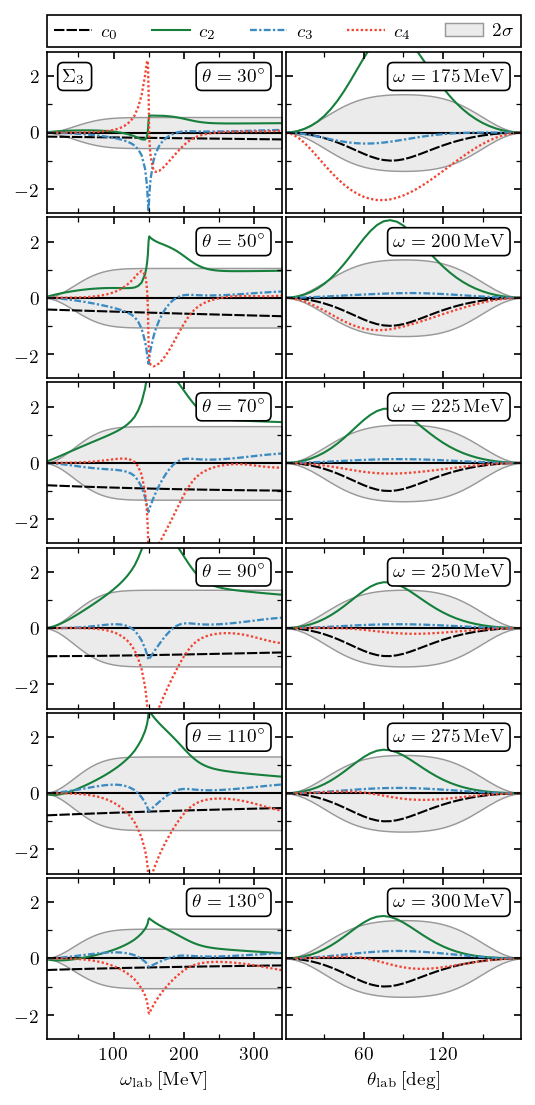

Fit kernel: RBFJump(length_scale=[50.7, 36.4]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.7138620238006801
3 [50, 75, 100, 125, 200, 225, 250]
Fit kernel: RBFJump(length_scale=[70.3, 43.8]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.49267338167653213
Fit kernel: RBFJump(length_scale=[67, 42.7]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.4179831735497057
Y [200, 225, 250]
Fit kernel: RBFJump(length_scale=[39.8, 53.9]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.5850575728011667


/Users/jordan.melendez/opt/miniconda3/envs/compton/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


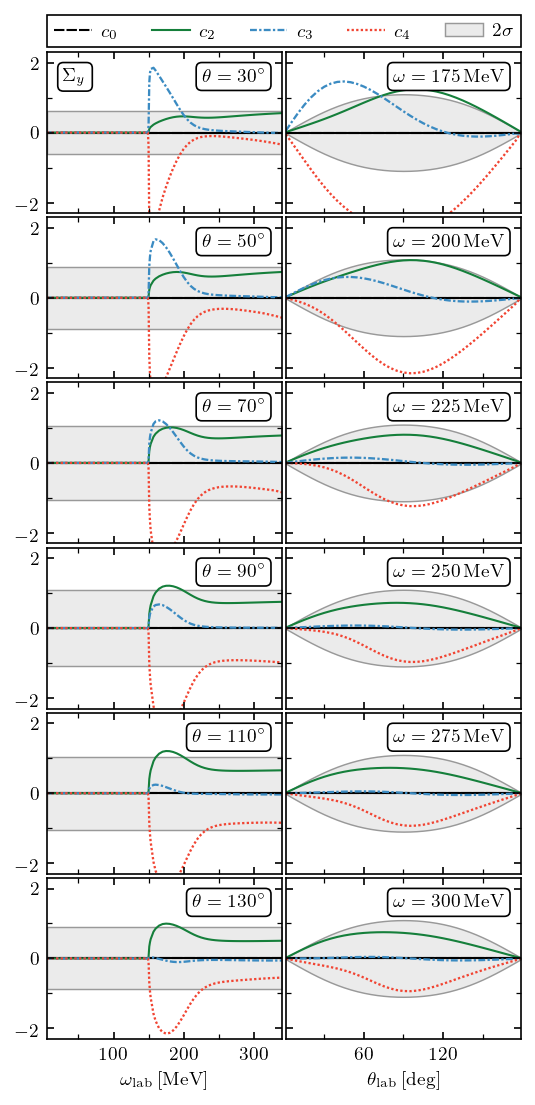

Fit kernel: RBFJump(length_scale=[40.5, 53.6]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.68141441535621
Y [200, 225, 250]
Fit kernel: RBFJump(length_scale=[60.3, 44.4]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.5765604879431933
Fit kernel: RBFJump(length_scale=[61.6, 44.1]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.6696746419481882
3Y [200, 225, 250]
Fit kernel: RBFJump(length_scale=[36.7, 46.3]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.7926474759338413


/Users/jordan.melendez/opt/miniconda3/envs/compton/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


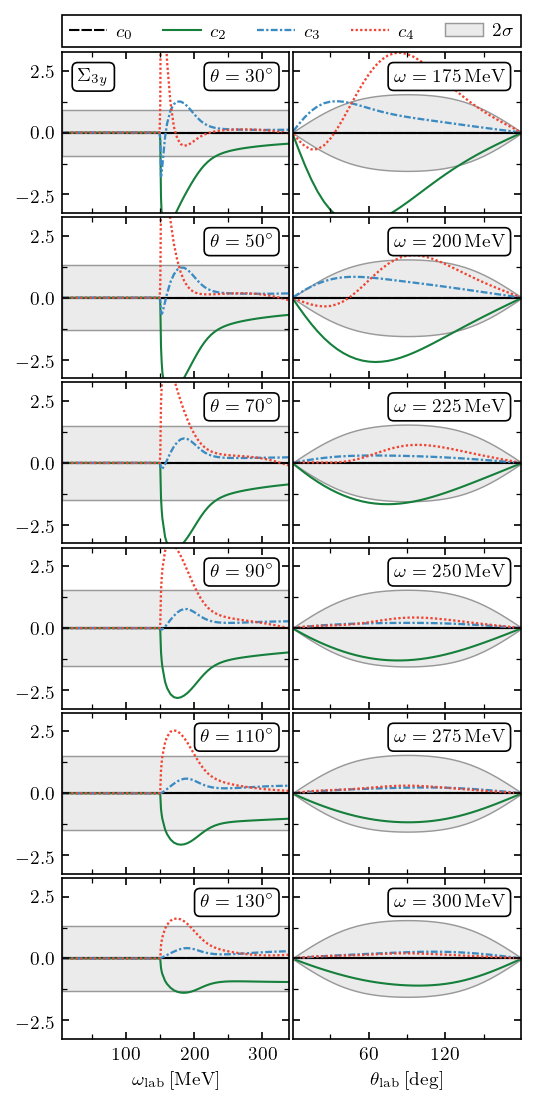

Fit kernel: RBFJump(length_scale=[36.6, 45.7]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.8848552364163734
3Y [200, 225, 250]
Fit kernel: RBFJump(length_scale=[60.5, 45.4]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.6637588156196279
Fit kernel: RBFJump(length_scale=[62.4, 44.9]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.7532418961320356
3Yp [200, 225, 250]
Fit kernel: RBFJump(length_scale=[40.8, 46]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.6300045745421434


/Users/jordan.melendez/opt/miniconda3/envs/compton/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


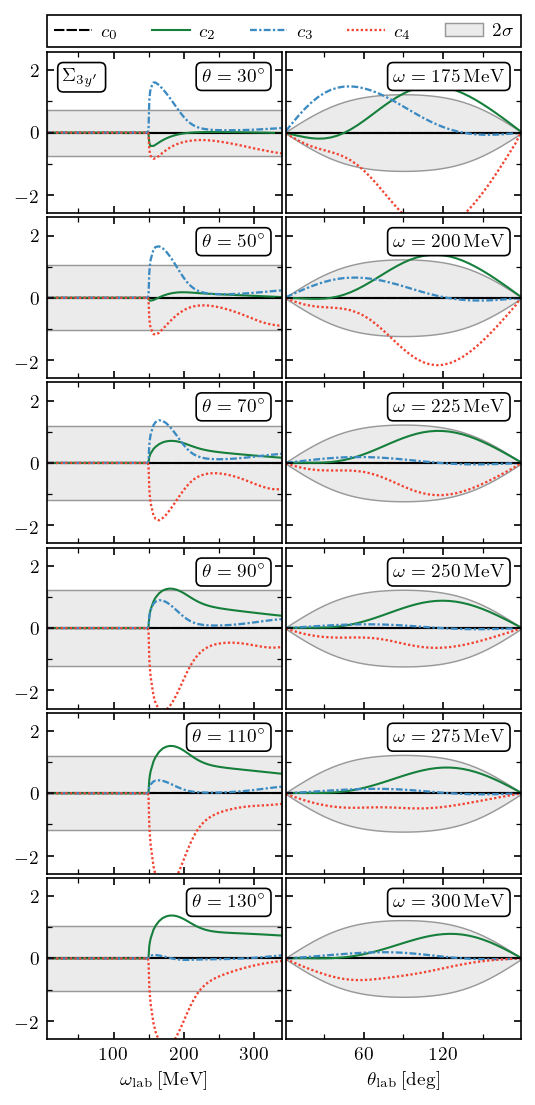

Fit kernel: RBFJump(length_scale=[41.5, 45.8]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.7269301802147774
3Yp [200, 225, 250]
Fit kernel: RBFJump(length_scale=[48.4, 46.6]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.6465415159562051
Fit kernel: RBFJump(length_scale=[49.5, 46.4]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.7497692037847029
1Xp [200, 225, 250]
Fit kernel: RBFJump(length_scale=[37.8, 47.9]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.6495997938668998


/Users/jordan.melendez/opt/miniconda3/envs/compton/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


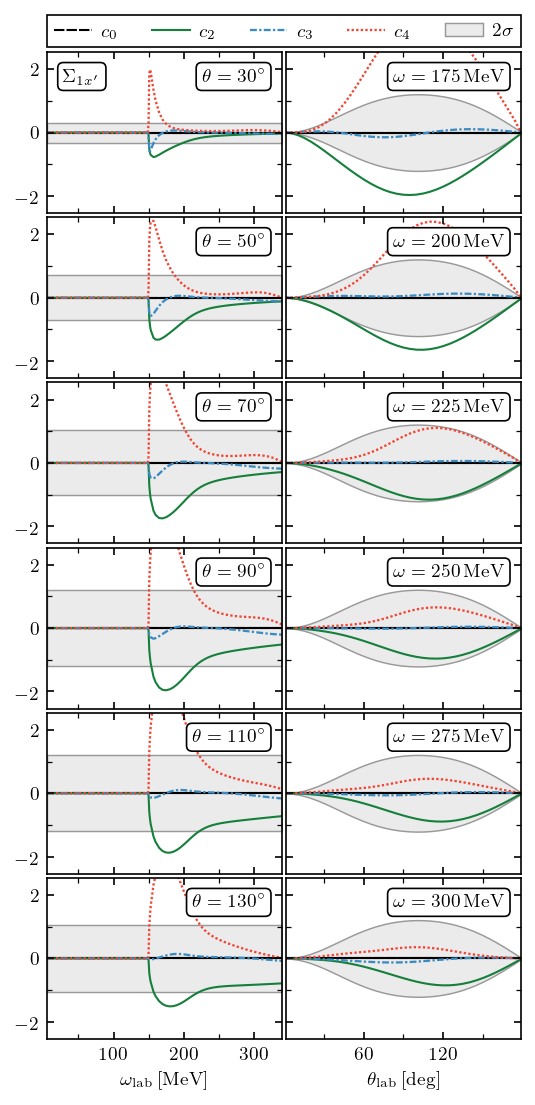

Fit kernel: RBFJump(length_scale=[38.3, 47.5]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.7488808950491421
1Xp [200, 225, 250]
Fit kernel: RBFJump(length_scale=[54.7, 42.9]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.4865277248862905
Fit kernel: RBFJump(length_scale=[55.9, 42.7]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.562857106429077
1Zp [200, 225, 250]
Fit kernel: RBFJump(length_scale=[33.3, 45.1]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.2903248855127756


/Users/jordan.melendez/opt/miniconda3/envs/compton/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


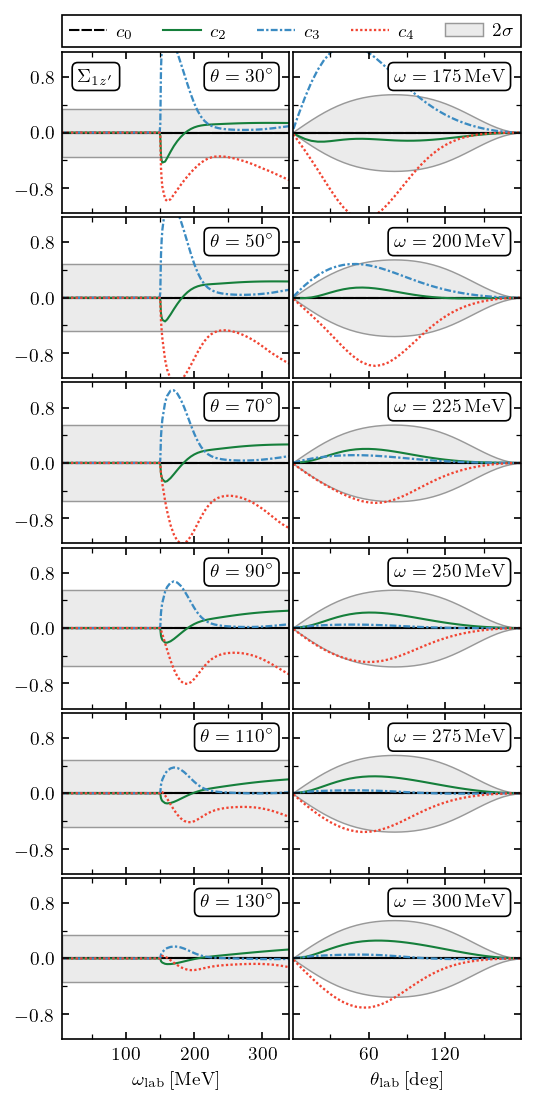

Fit kernel: RBFJump(length_scale=[33.3, 44.8]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.325190196198702
1Zp [200, 225, 250]
Fit kernel: RBFJump(length_scale=[54.4, 42.7]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.29307329353273026
Fit kernel: RBFJump(length_scale=[54.8, 42.1]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.31899834512843045
2Xp [50, 75, 100, 125, 200, 225, 250]
Fit kernel: RBFJump(length_scale=[31.6, 58.4]) + WhiteKernel(noise_level=0.0001)
cbar mean: 1.1530968486102144
[[0]
 [0]] [0. 1.]


/Users/jordan.melendez/opt/miniconda3/envs/compton/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


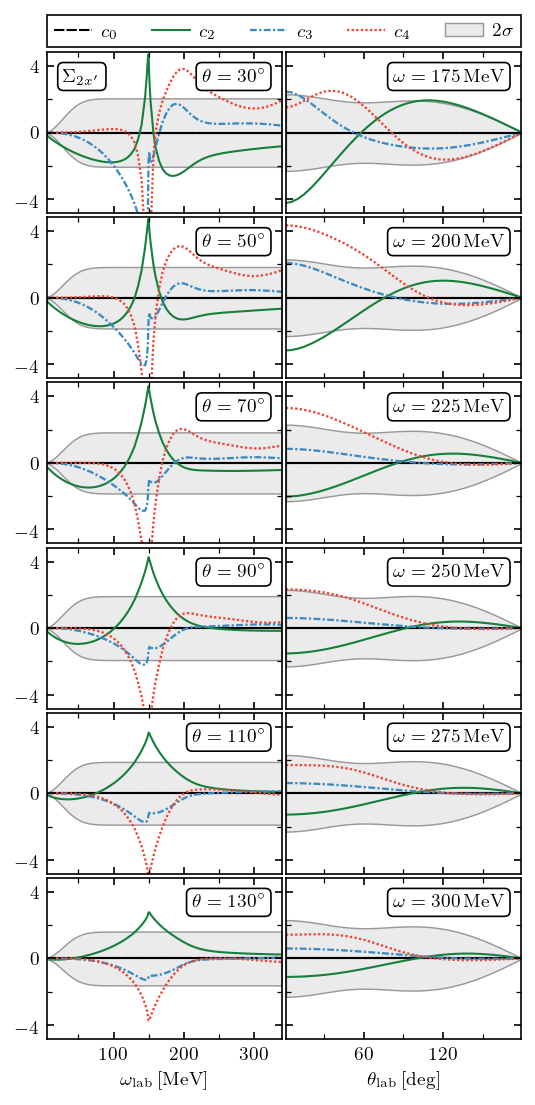

Fit kernel: RBFJump(length_scale=[32.4, 60]) + WhiteKernel(noise_level=0.0001)
cbar mean: 1.1988147995172502
2Xp [50, 75, 100, 125, 200, 225, 250]
Fit kernel: RBFJump(length_scale=[40.4, 53.4]) + WhiteKernel(noise_level=0.0001)
cbar mean: 1.3408985693056164
Fit kernel: RBFJump(length_scale=[42, 53.5]) + WhiteKernel(noise_level=0.0001)
cbar mean: 1.5179059407944404
2Zp [50, 75, 100, 125, 200, 225, 250]
Fit kernel: RBFJump(length_scale=[34, 52]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.7211389458191728
[[0]
 [0]] [0. 1.]


/Users/jordan.melendez/opt/miniconda3/envs/compton/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


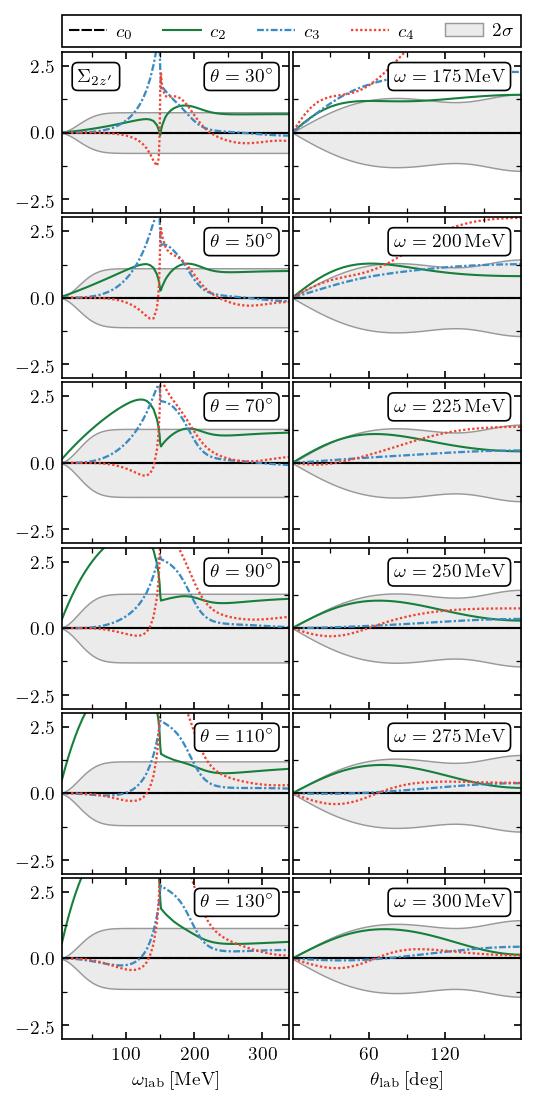

Fit kernel: RBFJump(length_scale=[33.9, 54.6]) + WhiteKernel(noise_level=0.0001)
cbar mean: 0.7873380432827644
2Zp [50, 75, 100, 125, 200, 225, 250]
Fit kernel: RBFJump(length_scale=[47.9, 57.4]) + WhiteKernel(noise_level=0.0001)
cbar mean: 1.797354511475823
Fit kernel: RBFJump(length_scale=[41.5, 57.8]) + WhiteKernel(noise_level=0.0001)
cbar mean: 1.7464963244941598


In [35]:
analyzers = {}
analyzers_phillips_Q = {}

for obs, system in product(observables_unique, ['proton', 'neutron']):
    obs_no_tex = observables_name_inverse_map[obs]
        
    df_i = df[(df['observable'] == obs) & (df['nucleon'] == system)]
    X = df_i[['omegalab [MeV]', 'thetalab [deg]']].values
    y = df_i[['y0', 'y2', 'y3', 'y4']].values
    
    degrees_zeros = None
    omega_zeros = None
    omega_deriv_zeros = None
    if obs_no_tex in zero_at_t_0_and_180:
        degrees_zeros = [0, 180]
    elif obs_no_tex in ['2Xp']:
        degrees_zeros = [180]
    elif obs_no_tex in ['2Zp']:
        degrees_zeros = [0]
        
    degrees_deriv_zeros = None
    if obs_no_tex in c_deriv_zero_at_t0 and obs_no_tex in c_deriv_zero_at_t180:
        degrees_deriv_zeros = [0, 180]
    elif obs_no_tex in c_deriv_zero_at_t0:
        degrees_deriv_zeros = [0]
    elif obs_no_tex in c_deriv_zero_at_t180:
        degrees_deriv_zeros = [180]

    if obs == dsg_label or obs_no_tex in nonzero_below_threshold:
        omega_zeros = [0]
        omega_deriv_zeros = [0]

    ref = 1.
    if obs == dsg_label:
        ref = df_dsg_ref['ref'][df_dsg_ref['nucleon'] == system].values

        if system == 'proton':
            height = 4
            print('height', height)
            width = 350
            width_degrees = 90
            dsg_scale_lorentz = ref_scale(
                X[:, 0], omega_lab_cusp, X[:, 1], height=height,
                width=width, degrees_width=width_degrees
            )
            ref = ref * dsg_scale_lorentz
    
    if (obs_no_tex not in nonzero_below_threshold) and obs != dsg_label:
        train = train_above_cusp
        omegas = [175, 200, 225, 250, 275, 300]
        print(obs_no_tex, train_high_energies, flush=True)
    else:
        train = train_all
        omegas = [175, 200, 225, 250, 275, 300]
        print(obs_no_tex, train_low_energies + train_high_energies, flush=True)
        
    thetas = train_degrees
        
    if (obs_no_tex not in nonzero_below_threshold) or (obs_no_tex in nonzero_at_leading_order):
        excluded = [0]
    else:
        excluded = [0, 2]
        
        
    kern_nugget = 1e-4
    kernel = RBFJump(
        length_scale=[100, 50], length_scale_bounds=(1, 200),
        jump=[omega_lab_cusp, np.inf],
    ) + WhiteKernel(kern_nugget, 'fixed')
    
    use_delta_transition = True
    
    # The degrees of freedom impacts the factor posterior values
    gp_df = 1
    
    analyzer = ConvergenceAnalyzer(
        obs, system.capitalize(), X, y, orders, train=train, ref=ref,
        delta_transition=use_delta_transition,
        breakdown=breakdown, excluded=excluded, kernel=kernel, n_restarts_optimizer=0,
        df=gp_df, exp_param='halfsum', degrees_zeros=degrees_zeros, omega_zeros=omega_zeros,
        omega_deriv_zeros=omega_deriv_zeros, degrees_deriv_zeros=degrees_deriv_zeros,
    )
    analyzers[obs, system.capitalize()] = analyzer
    if system == 'proton':
        with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
            analyzer.plot_coefficient_slices(omegas, thetas)
            fig = plt.gcf()
            fig.savefig(f'manuscript_figures/coeffs_slices_{obs_no_tex}')
            plt.show()
        
        
    analyzer_phil = ConvergenceAnalyzer(
        obs, system.capitalize(), X, y, orders, train=train, ref=ref,
        delta_transition=use_delta_transition,
        breakdown=breakdown, exp_param='phillips', excluded=excluded, kernel=kernel,
        df=gp_df
    )
    analyzers_phillips_Q[obs, system.capitalize()] = analyzer_phil
#     break

In [36]:
data_gps = []
for obs, nucleon in product(observables_unique, ['Proton', 'Neutron']):
    analyzer = analyzers[obs, nucleon]
    
    cbar = analyzer.cbar
    ls_w, ls_t = analyzer.gp.kernel_.k1.get_params()['length_scale']
    
    data_gps.append([obs, cbar, ls_w, ls_t, nucleon])

In [37]:
df_gps = pd.DataFrame(data_gps, columns=['obs', 'cbar', 'ls omega', 'ls theta', 'nucleon'])
df_gps = df_gps.set_index('obs')
df_gps.index = pd.Categorical(df_gps.index, observables_unique, ordered=True)

In [38]:
df_gps

,cbar,ls omega,ls theta,nucleon
$\mathrm{d}\sigma$,0.910106,56.847220,64.065037,Proton
$\mathrm{d}\sigma$,3.153032,39.974905,77.759283,Neutron
$\Sigma_{1x}$,0.727870,35.604708,47.258962,Proton
$\Sigma_{1x}$,0.683310,57.720291,49.388304,Neutron
$\Sigma_{1z}$,0.458056,33.724829,54.519457,Proton
$\Sigma_{1z}$,0.403168,55.517472,42.495059,Neutron
$\Sigma_{2x}$,0.566090,41.004599,37.959512,Proton
$\Sigma_{2x}$,0.700421,49.833232,39.296620,Neutron
$\Sigma_{2z}$,1.485458,47.400980,46.088649,Proton
$\Sigma_{2z}$,2.076708,45.854908,52.715733,Neutron


In [39]:
df_gps_pivot = df_gps.pivot(columns='nucleon').swaplevel(0, 1, axis=1).sort_values('nucleon', axis=1, ascending=False)
df_gps_pivot

nucleon               Proton                         Neutron             \
                        cbar   ls omega   ls theta      cbar   ls omega   
$\mathrm{d}\sigma$  0.910106  56.847220  64.065037  3.153032  39.974905   
$\Sigma_{1x}$       0.727870  35.604708  47.258962  0.683310  57.720291   
$\Sigma_{1z}$       0.458056  33.724829  54.519457  0.403168  55.517472   
$\Sigma_{2x}$       0.566090  41.004599  37.959512  0.700421  49.833232   
$\Sigma_{2z}$       1.485458  47.400980  46.088649  2.076708  45.854908   
$\Sigma_{3}$        0.691172  50.465532  35.527857  0.492673  70.342945   
$\Sigma_{y}$        0.585058  39.769069  53.885678  0.576560  60.305277   
$\Sigma_{3y}$       0.792647  36.689254  46.285674  0.663759  60.543023   
$\Sigma_{3y'}$      0.630005  40.827694  46.035533  0.646542  48.382417   
$\Sigma_{1x'}$      0.649600  37.753785  47.899580  0.486528  54.741944   
$\Sigma_{1z'}$      0.290325  33.329238  45.106617  0.293073  54.443459   
$\Sigma_{2x'}$      1.153097  31.634533  58.363625  1.340899  40.432863   
$\Sigma_{2z'}$      0.721139  33.994164  52.003030  1.797355  47.896032   

nucleon                        
                     ls theta  
$\mathrm{d}\sigma$  77.759283  
$\Sigma_{1x}$       49.388304  
$\Sigma_{1z}$       42.495059  
$\Sigma_{2x}$       39.296620  
$\Sigma_{2z}$       52.715733  
$\Sigma_{3}$        43.822673  
$\Sigma_{y}$        44.350421  
$\Sigma_{3y}$       45.439530  
$\Sigma_{3y'}$      46.616383  
$\Sigma_{1x'}$      42.868979  
$\Sigma_{1z'}$      42.744387  
$\Sigma_{2x'}$      53.360515  
$\Sigma_{2z'}$      57.371992

In [40]:
print(df_gps_pivot.to_latex(escape=False, float_format='{:0.2g}'.format))

\begin{tabular}{lrrrrrr}
\toprule
nucleon & \multicolumn{3}{l}{Proton} & \multicolumn{3}{l}{Neutron} \\
{} &   cbar & ls omega & ls theta &    cbar & ls omega & ls theta \\
\midrule
$\mathrm{d}\sigma$ &   0.91 &       57 &       64 &     3.2 &       40 &       78 \\
$\Sigma_{1x}$      &   0.73 &       36 &       47 &    0.68 &       58 &       49 \\
$\Sigma_{1z}$      &   0.46 &       34 &       55 &     0.4 &       56 &       42 \\
$\Sigma_{2x}$      &   0.57 &       41 &       38 &     0.7 &       50 &       39 \\
$\Sigma_{2z}$      &    1.5 &       47 &       46 &     2.1 &       46 &       53 \\
$\Sigma_{3}$       &   0.69 &       50 &       36 &    0.49 &       70 &       44 \\
$\Sigma_{y}$       &   0.59 &       40 &       54 &    0.58 &       60 &       44 \\
$\Sigma_{3y}$      &   0.79 &       37 &       46 &    0.66 &       61 &       45 \\
$\Sigma_{3y'}$     &   0.63 &       41 &       46 &    0.65 &       48 &       47 \\
$\Sigma_{1x'}$     &   0.65 &       38 &       48 &  

In [41]:
df_gps.to_csv('gp_hyperparameters.csv')

In [42]:
from matplotlib.ticker import AutoMinorLocator

## Observable coefficients (fig. 1)<a id="observable_coefficients"></a>

[[0]
 [0]] [0. 1.]


/Users/jordan.melendez/opt/miniconda3/envs/compton/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


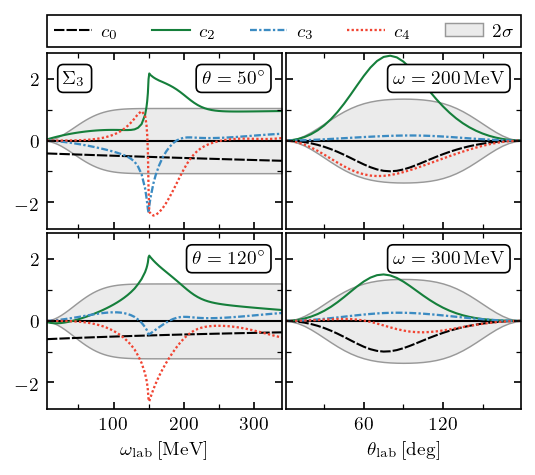

In [43]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, axes = plt.subplots(2,2, figsize=(3.4, 3), sharex='col', sharey=True)

    obs_plot = r'$\Sigma_{3}$'
    obs_no_tex_plot = observables_name_inverse_map[obs_plot]
    analyzers[obs_plot, 'Proton'].plot_coefficient_slices([200, 300], [50, 120], axes=axes)
    axes[0, 0].yaxis.set_minor_locator(AutoMinorLocator(2))
    fig.savefig(f'manuscript_figures/coeffs_obs-{obs_no_tex_plot}')
    plt.show()

[[0]
 [0]] [0. 1.]


/Users/jordan.melendez/opt/miniconda3/envs/compton/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


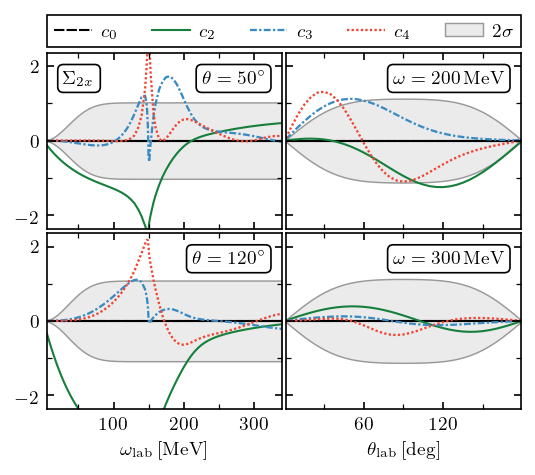

In [44]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, axes = plt.subplots(2,2, figsize=(3.4, 3), sharex='col', sharey=True)

    obs_plot = r'$\Sigma_{2x}$'
    obs_no_tex_plot = observables_name_inverse_map[obs_plot]
    analyzers[obs_plot, 'Proton'].plot_coefficient_slices([200, 300], [50, 120], axes=axes)
    axes[0, 0].yaxis.set_minor_locator(AutoMinorLocator(2))
    fig.savefig(f'manuscript_figures/coeffs_obs-{obs_no_tex_plot}')
    plt.show()

In [45]:
factors = np.linspace(0.05, 3, 100)
# factors_prior = 1 / factors
factors_prior = 1

Q_posteriors_sum = {}
Q_posteriors_phil = {}
Q_bayes_factors = {}

for obs, nucleon in product(observables_unique, ['Proton', 'Neutron']):
    analyzer = analyzers[obs, nucleon]
    analyzer_phil = analyzers_phillips_Q[obs, nucleon]
    Q_log_post_i = np.array([analyzer.log_marginal_likelihood(factor=factor) for factor in factors])
    Q_log_post_i += np.log(factors_prior)
    Q_log_post_i_norm = Q_log_post_i - Q_log_post_i.max()
    Q_post_i_norm = np.exp(Q_log_post_i_norm) / np.trapz(np.exp(Q_log_post_i_norm), factors)
    Q_marg_like_i = np.trapz(np.exp(Q_log_post_i), factors)
    
    Q_phil_marg_like_i = np.exp(analyzer_phil.log_marginal_likelihood())

    Q_posteriors_sum[obs, nucleon] = Q_post_i_norm
    Q_posteriors_phil[obs, nucleon] = Q_phil_marg_like_i
    Q_bayes_factors[obs, nucleon] = Q_marg_like_i / Q_phil_marg_like_i

/Users/jordan.melendez/repos/gsum/gsum/models.py:882: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.32067986e-06,  2.03741883e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/Users/jordan.melendez/repos/gsum/gsum/models.py:882: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.29077611e-05, -1.27190865e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 8, 'warnflag': 2}
  ConvergenceWarning)
/Users/jordan.melendez/repos/gsum/gsum/models.py:882: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([2.40585555e-06, 1.53250871e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 7, 'warnflag': 2}
  ConvergenceWarning)
/Users/jordan.melendez/repos/gsum/gsum/models.py:882: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-8.2

In [46]:
# combined_post = np.ones(factors.shape[0])
Q_posteriors_sum['All', 'Proton'] = np.ones(factors.shape[0])
Q_posteriors_sum['All', 'Neutron'] = np.ones(factors.shape[0])
for obs, nucleon in product(observables_unique, ['Proton', 'Neutron']):
    Q_posteriors_sum['All', nucleon] += np.log(Q_posteriors_sum[obs, nucleon])
    
Q_posteriors_sum['All', 'Proton'] -= Q_posteriors_sum['All', 'Proton'].max()
Q_posteriors_sum['All', 'Neutron'] -= Q_posteriors_sum['All', 'Neutron'].max()
Q_posteriors_sum['All', 'Proton'] = np.exp(Q_posteriors_sum['All', 'Proton'])
Q_posteriors_sum['All', 'Neutron'] = np.exp(Q_posteriors_sum['All', 'Neutron'])

In [47]:
Q_posteriors_sum

{('$\\mathrm{d}\\sigma$',
  'Proton'): array([4.37034130e-80, 2.13685376e-66, 2.72684475e-58, 6.86799415e-53,
        2.11245112e-34, 1.48593496e-29, 1.96712006e-25, 7.29970928e-22,
        9.75522470e-19, 5.53981821e-16, 1.49867766e-13, 2.09793894e-11,
        1.61891684e-09, 7.25172608e-08, 1.97278650e-06, 3.39933385e-05,
        3.86406877e-04, 3.01582289e-03, 1.68072743e-02, 6.94543318e-02,
        2.20485061e-01, 5.55337467e-01, 1.14206662e+00, 1.96613034e+00,
        2.89455232e+00, 3.71055546e+00, 4.20522815e+00, 4.26770527e+00,
        3.92056618e+00, 3.29031207e+00, 2.54251327e+00, 1.82120185e+00,
        1.21637411e+00, 7.61415452e-01, 4.48741202e-01, 2.50007868e-01,
        1.32155530e-01, 6.65025298e-02, 3.19551058e-02, 1.47034721e-02,
        6.49562564e-03, 2.76194683e-03, 1.13295414e-03, 4.49331493e-04,
        1.72657385e-04, 6.44065025e-05, 2.33680777e-05, 8.26133720e-06,
        2.85077157e-06, 9.61782576e-07, 3.17746000e-07, 1.02950408e-07,
        3.27602923e-08, 1.

In [48]:
observables_all_order = np.concatenate([['All'], observables_unique])

In [49]:
observables_all_order

array(['All', '$\\mathrm{d}\\sigma$', '$\\Sigma_{1x}$', '$\\Sigma_{1z}$',
       '$\\Sigma_{2x}$', '$\\Sigma_{2z}$', '$\\Sigma_{3}$',
       '$\\Sigma_{y}$', '$\\Sigma_{3y}$', "$\\Sigma_{3y'}$",
       "$\\Sigma_{1x'}$", "$\\Sigma_{1z'}$", "$\\Sigma_{2x'}$",
       "$\\Sigma_{2z'}$"], dtype='<U18')

In [50]:
Q_posteriors_sum_df = pd.DataFrame.from_dict(Q_posteriors_sum)
# Q_posteriors_sum_df.index.names = [r'pdf']
Q_posteriors_sum_df['Factor'] = factors
Q_posteriors_sum_df[r'$\Lambda_b$ [MeV]'] = breakdown / factors
Q_posteriors_sum_df = Q_posteriors_sum_df.set_index(['Factor', r'$\Lambda_b$ [MeV]'], drop=True)
# Q_posteriors_sum_df.index.names = ['obs', 'nucleon']
# Q_posteriors_sum_df = Q_posteriors_sum_df.reset_index()
# Q_posteriors_sum_df = Q_posteriors_sum_df.T

Q_posteriors_sum_df = Q_posteriors_sum_df.stack(level=[0, 1])
Q_posteriors_sum_df.index.names = ['Factor', r'$\Lambda_b$ [MeV]', 'obs', 'nucleon']
Q_posteriors_sum_df = Q_posteriors_sum_df.reset_index()
Q_posteriors_sum_df = Q_posteriors_sum_df.rename({0: 'pdf'}, axis=1)
Q_posteriors_sum_df['obs'] = pd.Categorical(Q_posteriors_sum_df['obs'], observables_all_order, ordered=True)
Q_posteriors_sum_df = Q_posteriors_sum_df.sort_values(by=['obs', 'Factor'])


In [51]:
Q_posteriors_sum_df

,Factor,$\Lambda_b$ [MeV],obs,nucleon,pdf
26,0.050000,13000.000000,All,Neutron,0.000000e+00
27,0.050000,13000.000000,All,Proton,0.000000e+00
54,0.079798,8145.569620,All,Neutron,0.000000e+00
55,0.079798,8145.569620,All,Proton,0.000000e+00
82,0.109596,5930.875576,All,Neutron,0.000000e+00
...,...,...,...,...,...
2729,2.940404,221.058056,$\Sigma_{2z'}$,Proton,1.888056e-11
2756,2.970202,218.840333,$\Sigma_{2z'}$,Neutron,2.336133e-29
2757,2.970202,218.840333,$\Sigma_{2z'}$,Proton,7.836699e-12
2784,3.000000,216.666667,$\Sigma_{2z'}$,Neutron,5.301268e-30


In [52]:
Q_bayes_factors

{('$\\mathrm{d}\\sigma$', 'Proton'): 6.582084195412316e+18,
 ('$\\mathrm{d}\\sigma$', 'Neutron'): 7.260615319912226e+26,
 ('$\\Sigma_{1x}$', 'Proton'): 2.92878192821311e+17,
 ('$\\Sigma_{1x}$', 'Neutron'): 3289269301956337.5,
 ('$\\Sigma_{1z}$', 'Proton'): 7.1653177316058825e+19,
 ('$\\Sigma_{1z}$', 'Neutron'): 3.834019967796016e+20,
 ('$\\Sigma_{2x}$', 'Proton'): 5.880926764746026e+18,
 ('$\\Sigma_{2x}$', 'Neutron'): 2.6359860771008676e+18,
 ('$\\Sigma_{2z}$', 'Proton'): 1.6365174687459757e+17,
 ('$\\Sigma_{2z}$', 'Neutron'): 3.078455289977739e+25,
 ('$\\Sigma_{3}$', 'Proton'): 25758710684002.363,
 ('$\\Sigma_{3}$', 'Neutron'): 428666.0616567583,
 ('$\\Sigma_{y}$', 'Proton'): 1.3637531043358523e+21,
 ('$\\Sigma_{y}$', 'Neutron'): 8.933230734280803e+18,
 ('$\\Sigma_{3y}$', 'Proton'): 1.1559739532002048e+21,
 ('$\\Sigma_{3y}$', 'Neutron'): 7212133006228356.0,
 ("$\\Sigma_{3y'}$", 'Proton'): 4.558300763018528e+22,
 ("$\\Sigma_{3y'}$", 'Neutron'): 2.6875822406304386e+20,
 ("$\\Sigma_{1x'}

In [53]:
Q_bayes_factors_df = pd.DataFrame.from_dict(Q_bayes_factors, orient='index', )

In [54]:
Q_bayes_factors_df

,0
"($\mathrm{d}\sigma$, Proton)",6.582084e+18
"($\mathrm{d}\sigma$, Neutron)",7.260615e+26
"($\Sigma_{1x}$, Proton)",2.928782e+17
"($\Sigma_{1x}$, Neutron)",3.289269e+15
"($\Sigma_{1z}$, Proton)",7.165318e+19
"($\Sigma_{1z}$, Neutron)",3.834020e+20
"($\Sigma_{2x}$, Proton)",5.880927e+18
"($\Sigma_{2x}$, Neutron)",2.635986e+18
"($\Sigma_{2z}$, Proton)",1.636517e+17
"($\Sigma_{2z}$, Neutron)",3.078455e+25


In [55]:
import seaborn as sns

In [56]:
from compton.graphs import pdfplot

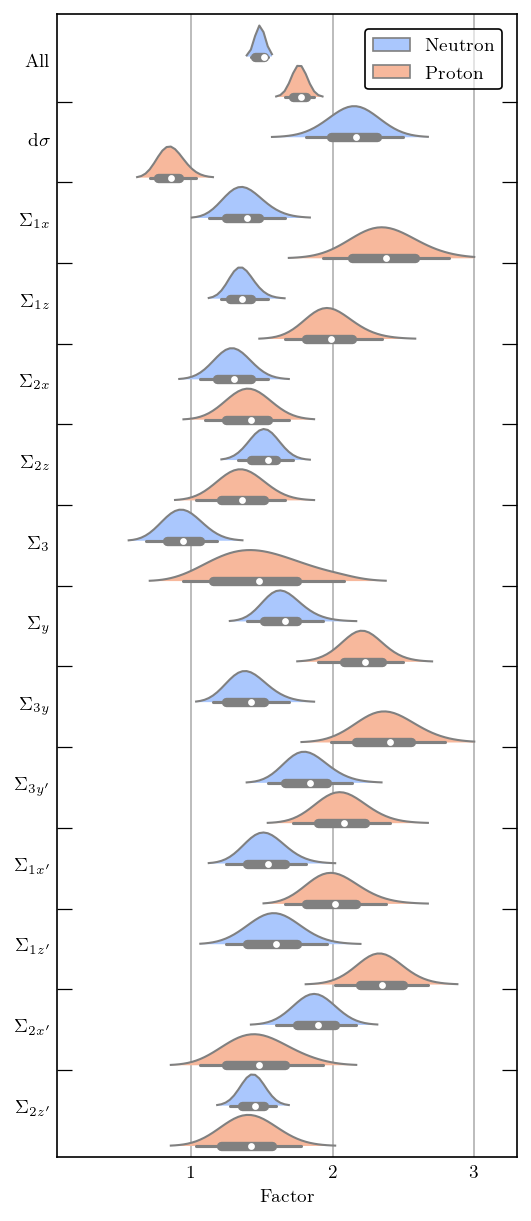

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(3.4, 8))
pdfplot(
    'Factor', 'obs', 'pdf', data=Q_posteriors_sum_df, hue='nucleon',
    linewidth=1, palette='coolwarm', ax=ax, margin=0.3, 
)
ax.set_xticks([1, 2, 3])
ax.margins(y=0.01)
ax.set_xlim(factors[0], 1.1*factors[-1])
ax.grid(axis='x');
fig.savefig('manuscript_figures/Q_factor_posterior.png')

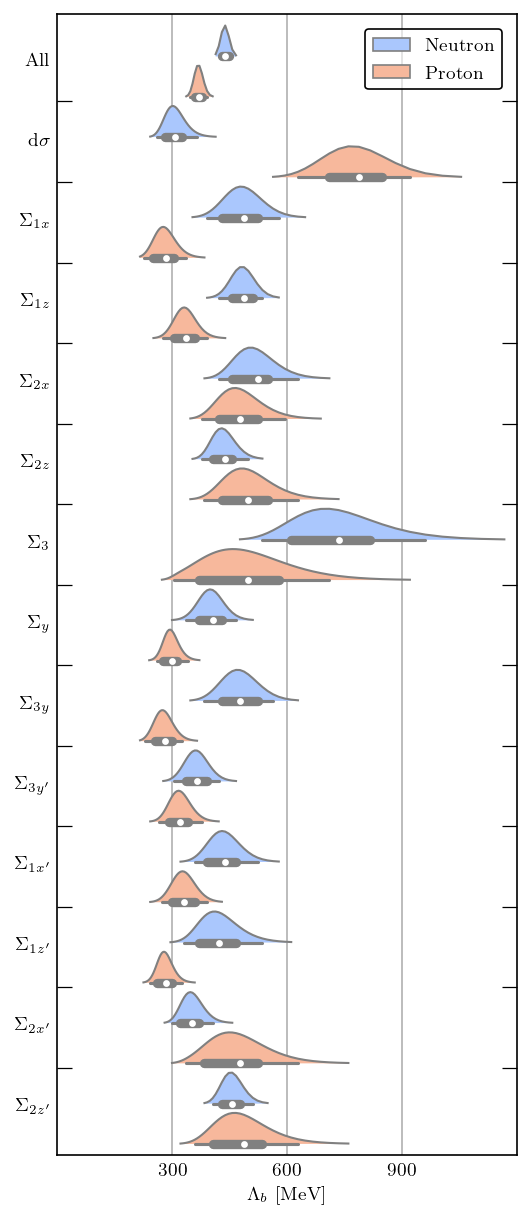

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(3.4, 8))
pdfplot(
    r'$\Lambda_b$ [MeV]', 'obs', 'pdf',
    data=Q_posteriors_sum_df.sort_values(by=['obs', r'$\Lambda_b$ [MeV]']),
    hue='nucleon',
    linewidth=1, palette='coolwarm', ax=ax, margin=0.3, 
)
ax.set_xticks([300, 600, 900])
ax.margins(y=0.01)
ax.set_xlim(0, 1200)
ax.grid(axis='x');
fig.savefig('manuscript_figures/Q_breakdown_posterior.png')